# Introduction
Automatic translation of languages is helpful for travelers, immigrants, or anyone who wants to communicate with people from another culture. This project seeks to solve the problem of machine translation from English to Spanish.

For this task I will use a sequence-sequence transformer model. A transformer is a neural network that learns context by tracking relationships in sequential data. This context is very useful for automatic translation of text. [5]

# Data
The data for this project was provided by Anki, a flashcard app for learning languages. The data is available for download through tensor flow's google API[1]. The dataset consists of 118,964 observations. Each observation consists of a sentence in English and its corresponding Spanish sentence. The max length for any sentence of either language is 248 characters. The English sentence could be seen as the only feature with structure (248,) and the Spanish sentence as the label with structure (248,).

# Exploratory Data Analysis

In [47]:
# !pip install -q --upgrade rouge-score
# !pip install -q --upgrade keras-nlp
# !pip install -q --upgrade keras

# Important Libraries
import keras_nlp
import pathlib
import random

import keras
from keras import ops
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning and Preprocessing
import re
import string
import tensorflow.strings as tf_strings
from keras.layers import TextVectorization

# Model Building and Training
import tensorflow as tf
from keras import layers
from tensorflow.keras.optimizers import Adam

# Results and Analysis
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [50]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import tensorflow.data as tf_data
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)

In [4]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Read text file and load into array as pairs
with open(text_file) as f:
  lines = f.read().split("\n")[:-1]
text_pairs = []

for line in lines:
  eng, spa = line.split("\t")
  spa = "[start] " + spa + " [end]"
  text_pairs.append((eng, spa))

In [9]:
# Examine 5 random examples of text pairs
for i in range(5):
  print(text_pairs[i])

('Go.', '[start] Ve. [end]')
('Go.', '[start] Vete. [end]')
('Go.', '[start] Vaya. [end]')
('Go.', '[start] Váyase. [end]')
('Hi.', '[start] Hola. [end]')


The example text pairs consist of short sentences which include capital letters, punctuation, and stopwords

In [ ]:
# Load sentence pairs into a dataframe for easier data analysis
eng_sentences = [pair[0] for pair in text_pairs]
span_sentences = [pair[1] for pair in text_pairs]

df = pd.DataFrame({'english': eng_sentences, 'spanish': span_sentences})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118964 entries, 0 to 118963
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  118964 non-null  object
 1   spanish  118964 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


English mean sentence length: 31.560488887394506
Spanish mean sentence length: 33.00633805184762


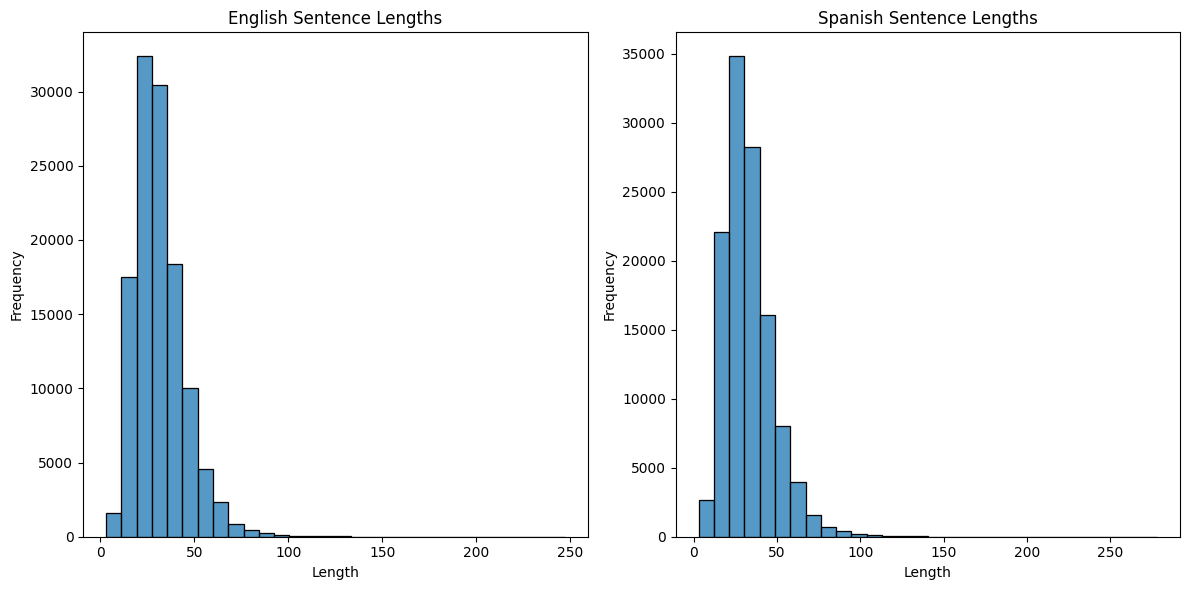

In [ ]:
eng_len = df['english'].apply(len)
span_len = df['spanish'].apply(len)

english_mean_len = eng_len.mean()
spanish_mean_len = span_len.mean()
print(f'English mean sentence length: {english_mean_len}')
print(f'Spanish mean sentence length: {spanish_mean_len}')

plt.figure(figsize=(12, 6))

# Plot histogram for 'eng_len'
plt.subplot(1, 2, 1)
sns.histplot(eng_len, kde=False, bins=30)
plt.title('English Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Plot histogram for 'span_len'
plt.subplot(1, 2, 2)
sns.histplot(span_len, kde=False, bins=30)
plt.title('Spanish Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The average sentence length is slightly longer for Spanish than for English. This disparity should be handled during preprocessing which will pad the sentences to be the same length

Average word count per English sentence: 6.310362798829898
Average word count per Spanish sentence: 6.083874113177096


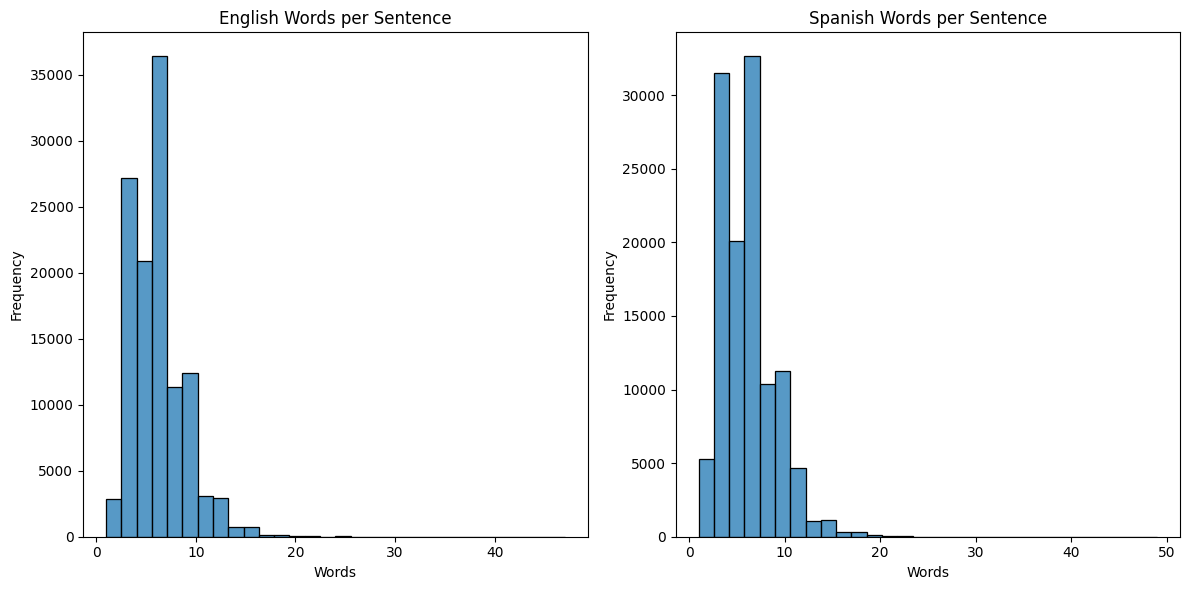

In [ ]:
def words_per_sentence(sentence: str) -> int:
  split_sentence = sentence.split(' ')
  return len(split_sentence)

eng_words = df['english'].apply(words_per_sentence)
span_words = df['spanish'].apply(words_per_sentence)
eng_word_mean = eng_words.mean()
span_word_mean = span_words.mean()
print(f'Average word count per English sentence: {eng_word_mean}')
print(f'Average word count per Spanish sentence: {span_word_mean}')

plt.figure(figsize=(12, 6))

# Plot histogram for 'eng_len'
plt.subplot(1, 2, 1)
sns.histplot(eng_words, kde=False, bins=30)
plt.title('English Words per Sentence')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Plot histogram for 'span_len'
plt.subplot(1, 2, 2)
sns.histplot(span_words, kde=False, bins=30)
plt.title('Spanish Words per Sentence')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plan of Analysis/Data Cleaning
Based on the EDA I will need to do some data cleaning before training my model. First, I will convert all capital letters to lowercase. Unlike German, Spanish and English do not use capital letters to convey meaning and inconsistent capitalization could lead to translation errors.

I will remove punctuation even though it sometimes conveys meaning. In a production setting I would create a different token for each punctuation mark but with this smaller dataset they are likely to confuse the model.

I did not remove numbers because there are instances in the dataset where these symbols convey meaning. There is one sentence pair where '5' is translated to 'cinco'. I want to preserve these instances.

Next, I will tokenize the sentences using a different tokenizer for English and Spanish. This process involves building a vocabulary list for both languages, splitting sentences into individual words, then assigning an integer value to each word.

I added a start token and end token to each Spanish sentence so the model knows when to stop predicting new Spanish words.

There are some natural language processing steps which are not necessary for this dataset including removing URLs, HTML tags, and correcting spelling errors. This dataset is obtained from a flashcard application so should be error-free.

Since the goal of the project is to translate sentences word-for-word, I will not standardize the words using stemming or lemmatization. These methods would remove meaning from the data.

As can be seen from the graphs above there are some very short sentences in the dataset. I will not remove these as outliers since they add variety to the dataset. There are also instances where a user would want to translate a one or two word sentence including greetings and commands.

In [12]:
# Split data into training, validation, and test sets
random.shuffle(text_pairs)
# 15% for validation
num_val_samples = int(0.15 * len(text_pairs))
# 70% for training, 15% for testing
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [13]:
# Custom standardization for Spanish sentences to preserve start/end tokens
punctuation = string.punctuation + '¿'
punctuation = punctuation.replace('[', '')
punctuation = punctuation.replace(']', '')

def standardize_text(input_string: str) -> str:
  lowercase = tf_strings.lower(input_string)
  return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(punctuation), "")

In [17]:
vocab_size = 15000
MAX_SEQUENCE_LENGTH = 40
BATCH_SIZE = 64

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH + 1,
    standardize=standardize_text,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

The encoder-decoder Transformer model will predict the next word in the target sentence at each training step. It will use the English sentence and Spanish sentence so far to make this prediction. I added START and END tokens to each Spanish sentence so the model knows when to stop predicting new words. This structure is essential to allowing the model to translate word-by-word.

In [16]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            # because decoder needs to predict next word in sequence the input should be preceding words
            "decoder_inputs": spa[:, :-1],
        },
        # target sequence is offset by one
        spa[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


# Model Building and Training
Based on the structure of the data and the sequence-sequence task of translating sentences I will use an encoder-decoder Transformer architecture.

I will start with an positional embedding layer which makes the model aware of word order

The encoder layer analyses the input sequence and distills the meaning down to a context vector. The context vector summarizes the entire input sequence in a single fixed-length vector.

The decoder takes the context vector from the encoder and the target sequence so far. It seeks to predict the next words in the target sequence. Causal masking ensures the decoder only uses information from the target sequence so far. If it could use information from the future (what it is trying to predict) it would not be generalizable.

In [27]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # allow model to weigh different parts of input differently
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        # combine and compress information
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [32]:
# Assemble the Model
embed_dim = 256
latent_dim = 2048
num_heads = 8

# ENCODER
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

# DECODER
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_2    │ (None, None, 256)      │      3,850,240 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, None, 256)      │      3,155,456 │ positional_embedding_… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_9 (Functional) │ (None, None, 15000)    │     12,964,760 │ decoder_inputs[0][0],  │
│                           │                        │                │ transformer_encoder_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,970,456 (76.18 MB)

 Trainable params: 19,970,456 (76.18 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
transformer.compile(
    Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy']
)
history = transformer.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step - accuracy: 0.6939 - loss: 3.4134 - val_accuracy: 0.9182 - val_loss: 0.7393
Epoch 2/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 72s 51ms/step - accuracy: 0.9293 - loss: 0.6534 - val_accuracy: 0.9796 - val_loss: 0.3375
Epoch 3/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.9722 - loss: 0.3364 - val_accuracy: 0.9926 - val_loss: 0.1953
Epoch 4/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.9861 - loss: 0.2086 - val_accuracy: 0.9954 - val_loss: 0.1242
Epoch 5/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 84s 50ms/step - accuracy: 0.9915 - loss: 0.1396 - val_accuracy: 0.9965 - val_loss: 0.0846
Epoch 6/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9937 - loss: 0.0980 - val_accuracy: 0.9968 - val_loss: 0.0603
Epoch 7/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9952 - loss: 0.0708 - val_accuracy: 0.9969 - val_loss: 0.0461
Epoch 8/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 63s 48ms/step - accuracy: 0.9961 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


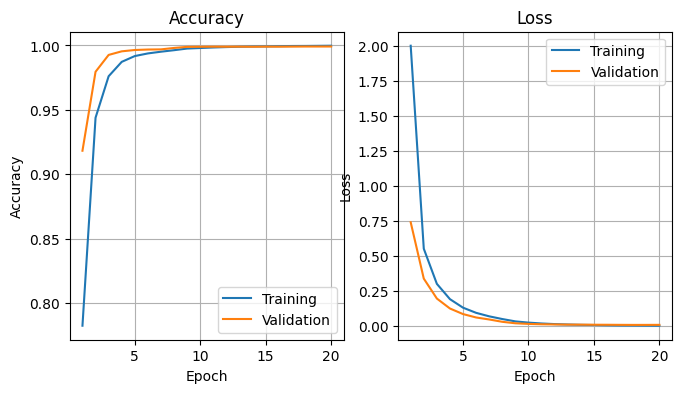

In [36]:
h = history.history
print(h.keys())
epoch_range = range(1, len(h['loss'])+1)

plt.figure(figsize=[12,4])
n = int(len(h.keys()) / 2)

# Plot accuracy
plt.subplot(1,3,1)
plt.plot(epoch_range, h['accuracy'], label='Training')
plt.plot(epoch_range, h['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.grid()
plt.legend()

# Plot Loss
plt.subplot(1,3,2)
plt.plot(epoch_range, h['loss'], label='Training')
plt.plot(epoch_range, h['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.grid()
plt.legend()

## Hyperparameter Tuning
I tried tuning multiple hyperparameters manually to improve the performance of the model. I started using rmsprop as the optimizer but switched to Adam. Both optimizers squash the learning rate based on the current loss function gradient but adam incorporates momentum differently. This results in a model that is better able to escape local minima in the loss gradient.

I also tried different learning rates. I started with the default adam rate of 0.001 which resulted in a validation accuracy of 0.9558. I decreased the learning rate to 0.0001 and increased the number of epochs to 20. This improved validation accuracy to 0.9992.

I tried multiple data preparation methods as well including padding input sentences to a fixed length.

## Qualitative Analysis
I will feed into the model tokenized English sentences from the test dataset which have not been seen by the model. The model outputs the probabilities of the next token which I will use to generate a translated sentence.

The test sentences were cleaned in the same way as the train and validation sentences. The will be encoded using the tokenizer built on the training set.

In [53]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

def decode_sequence(input_sentence, model):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(MAX_SEQUENCE_LENGTH):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        # returns probabilities of different words
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        # pick the most probable next word
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence, transformer)
    print(input_sentence, translated)

This sofa takes too much room. [start] abandonó compañía están día tenía                                   
Mary is a good-looking woman. [start] tom no hacerme querés                                    
The cage is open. [start] queráis tom espero                                     
Why does everything happen to me? [start] maría cuánto país de una                                   
I helped him yesterday. [start] asunto este vas                                     


In [56]:
# Evaluate Transformer Model on unseen data
bleu_scores = np.zeros((30,))
meteor_scores = np.zeros((30,))
for i, test_pair in enumerate(test_pairs[:30]):
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1].split(' ')

    translated_sentence = decode_sequence([input_sentence], transformer)
    translated_sentence = (
        translated_sentence.replace("[START]", "")
        .replace("[END]", "")
        .strip()
        .split(' ')
    )
    # Specify only 1 gram matches
    bleu = sentence_bleu([reference_sentence], translated_sentence, weights=(1, 0, 0, 0))
    meteor = meteor_score([reference_sentence], translated_sentence)
    bleu_scores[i] = bleu
    meteor_scores[i] = meteor

print(f'Average BLEU score: {np.mean(bleu_scores, axis=0)}')
print(f'Average METEOR score: {np.mean(meteor_scores, axis=0)}')


Average BLEU score: 0.12364004577219528
Average METEOR score: 0.0750118821478954


# Results and Analysis

Bilingual Evaluation Understudy (BLEU) focuses on precision-based features. It compares the machine translation to several reference translations and gives a score in the range [0,1] for the quality of the translation. It is based on the number of strings shared between the machine translation and the reference translation.[2] On the 30 unseen sentences my transformer model averaged 0.1236, which is pretty low.

Metric for Evaluation of Translation with Explicit Ordering (METEOR) scores machine translations on the sentence level. It accounts for synonyms and morphological variants and better reflects a human judge of translation quality.[5] It also gives a score in the range [0,1]. On the 30 unseen sentences my transformer model averaged 0.0750 which is not very high.

To further evaluate the performance of my encoder-decoder Transformed architecture I will compare it with a sequence-sequence LSTM model. Recurrent Neural Network models like LSTM or GRU were commonly used for machine translation before Transformers became popular

In [54]:

from tensorflow.keras.layers import LSTM, Dense

embed_dim = 256
latent_dim = 2048
num_heads = 8

# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size, embed_dim)(encoder_inputs)
# LSTM
encoder_lstm = keras.layers.LSTM(units=embed_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(x)
encoder_states = [state_h, state_c]
encoder = keras.Model(encoder_inputs, encoder_outputs)

# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
x = PositionalEmbedding(MAX_SEQUENCE_LENGTH, vocab_size, embed_dim)(decoder_inputs)
# LSTM
decoder_lstm = keras.layers.LSTM(units=embed_dim, return_sequences=True, return_state=True)
decoder_lstm_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder_lstm_outputs)

decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

model= keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="lstm")
model.summary()

Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_6    │ (None, None, 256)      │      3,850,240 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_7    │ (None, None, 256)      │      3,850,240 │ decoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 256), (None,   │        525,312 │ positional_embedding_… │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        525,312 │ positional_embedding_… │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, None, 15000)    │      3,855,000 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,606,104 (48.09 MB)

 Trainable params: 12,606,104 (48.09 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_history = transformer.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 63s 48ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0076
Epoch 2/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0077
Epoch 3/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9992 - val_loss: 0.0073
Epoch 4/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9999 - loss: 5.9874e-04 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 5/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accuracy: 0.9999 - loss: 8.3934e-04 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 6/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0076
Epoch 7/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.9999 - loss: 7.8556e-04 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 8/10
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - accura

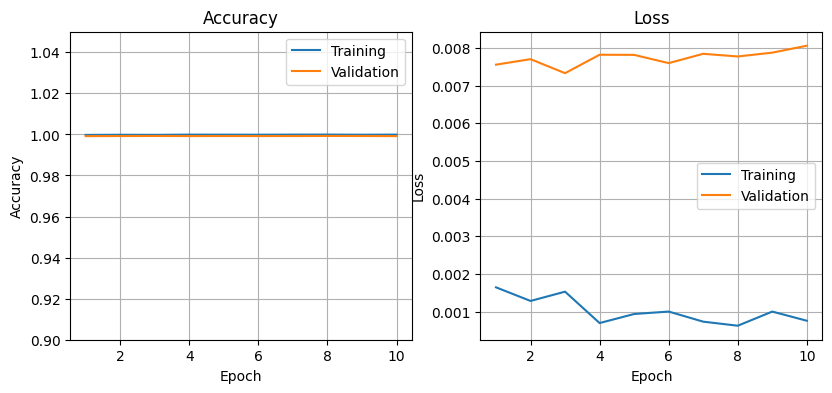

In [40]:
lh = lstm_history.history
epoch_range = range(1, len(lh['loss'])+1)

plt.figure(figsize=[15,4])
n = int(len(lh.keys()) / 2)

# Plot accuracy
plt.subplot(1,3,1)
plt.plot(epoch_range, lh['accuracy'], label='Training')
plt.plot(epoch_range, lh['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.ylim((0.90, 1.05))
plt.grid()
plt.legend()

# Plot Loss
plt.subplot(1,3,2)
plt.plot(epoch_range, lh['loss'], label='Training')
plt.plot(epoch_range, lh['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.grid()
plt.legend()

In [57]:
# Evaluate LSTM Model on unseen data
bleu_scores = np.zeros((30,))
meteor_scores = np.zeros((30,))
for i, test_pair in enumerate(test_pairs[:30]):
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1].split(' ')

    translated_sentence = decode_sequence([input_sentence], model)
    translated_sentence = (
        translated_sentence.replace("[START]", "")
        .replace("[END]", "")
        .strip()
        .split(' ')
    )
    # Specify only 1 gram matches
    bleu = sentence_bleu([reference_sentence], translated_sentence, weights=(1, 0, 0, 0))
    meteor = meteor_score([reference_sentence], translated_sentence)
    bleu_scores[i] = bleu
    meteor_scores[i] = meteor

print(f'Average BLEU score: {np.mean(bleu_scores, axis=0)}')
print(f'Average METEOR score: {np.mean(meteor_scores, axis=0)}')

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU score: 0.026016260162601626
Average METEOR score: 0.049886609470123425


# Conclusion and Discussion

The encoder-decoder Transformer model performed well during training achieving a validation accuracy of 0.9558 but did not perform well at the qualitative analysis; the translated example sentences were not close to the actual Spanish translations. It also did not perform well qualitatively on test data, achieving a BLEU score of 0.1236. The Transformer model outperformed the LSTM model according to BLEU score 0.1236 to 0.0260.

This disparity between loss and accuracy during training and the actual performance of the model at translating unseen data was the biggest challenge of the project. Initially, I used padding to make all input sentences the same length. The model was including all the [PAD] words when evaluating accuracy. I created a mask to remove all the padding words but accuracy during training remained suspiciously high and did not reflect the quality of the model. My final transformer model did not pad the input sentences to a fixed length. For loss function I used sparse_categorical_crossentropy between the vectorized target sentence and translated sentence.

Decoding text is computationally expensive, it took 80 seconds to decode the 30 test sentences after translation. It would not be feasible to decode the millions of sentences used during training using Google Colaboratory's free GPU resource. It would also result in a very complicated loss function. One way to improve the project would to use more computational resources and a loss function that evaluates the translation using the decoded sentences.


One of the dangers with neural networks is overfitting as the model learns more about the training data. There was some evidence of overfitting, the validation accuracy decreased after epoch 8. I included some regularization techniques to mitigate overfitting such as normalization layers.

To improve the model I could employ more regularization strategies to mitigate overfitting such as dropout layers and early stopping.

One way to improve the model for translation of longer sequences would be to include an attention mechanism. Attention mechanisms focus on the relevant input sentence areas and learn the alignment between relevant information.

# Citations
[1] https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

[2] https://defined.ai/blog/machine-translation-101-part-3

[3] https://www.kaggle.com/code/databeru/pt-en-translation-with-keras-blue-score

[4] https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

[5] https://blogs.nvidia.com/blog/what-is-a-transformer-model/